In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip household_power_consumption.zip
!pip install groq

--2025-07-31 06:52:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘household_power_consumption.zip’

household_power_con     [     <=>            ]  19.68M  22.2MB/s    in 0.9s    

2025-07-31 06:52:50 (22.2 MB/s) - ‘household_power_consumption.zip’ saved [20640916]

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.txt  
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 8.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns

def load_data():
    df = pd.read_csv('household_power_consumption.txt',
                     sep=';',
                     parse_dates={'datetime': ['Date', 'Time']},
                     infer_datetime_format=True,
                     na_values=['?'],
                     low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [3]:
df = load_data()
df.head()

/tmp/ipython-input-2444791740.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
/tmp/ipython-input-2444791740.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
/tmp/ipython-input-2444791740.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
import os
from groq import Groq
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Groq client with your API key and model
client = Groq(api_key=os.getenv("GROQ_API_KEY"))
model = "llama-3.1-8b-instant"

# Load the dataset into a pandas DataFrame (ensure `load_data()` is defined elsewhere)
df = load_data()
print(f"Data loaded: {df.shape[0]} records")

def generate_pandas_code(query, df_description):
    """
    Generates executable pandas code using Groq LLM based on a natural language query.
    The prompt includes dataset schema and time range, and instructs the model to respond with clean code.
    """
    system_prompt = f"""
    You are a data analyst with proficient knowledge of pandas, sql and groupby merge and other complex data visualisation methods. Generate pandas code for this query using the DataFrame 'df'.
    Dataset description:
    - Index: datetime (DateTimeIndex)
    - Columns: {', '.join(df.columns)}
    - Time range: {df.index.min()} to {df.index.max()}

    Rules:
    1. Use vectorized operations
    2. Handle datetime filtering properly
    3. Return ONLY executable code
    4. For plots: use matplotlib, include plt.show()
    5. Restrict your responses to the questions asked. do not respond with extra or unnecessary details.
    """

    # Send the prompt and query to the LLM to get generated code
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": query}
        ],
        model=model,
        temperature=0.1  # Low temperature for deterministic output
    )

    # Return only the content of the first completion
    return response.choices[0].message.content

def execute_query(query):
    """
    Executes user query by:
    1. Generating pandas code from the query using LLM
    2. Parsing and extracting the code block
    3. Executing the code safely with access to 'df' and 'plt'
    """
    print(f"Query: {query}")
    code = generate_pandas_code(query, df.describe())

    print("Generated Code:")
    print(code)

    # Extract code block from markdown format (```python ... ```)
    if "```python" in code and "```" in code:
        start = code.find("```python") + len("```python")
        end = code.find("```", start)
        code = code[start:end].strip()
    else:
        print("Warning: Code block not found. Using full code.")
        code = code.strip()

    try:
        # Execute the generated code in a controlled environment
        exec_globals = {'df': df, 'plt': plt}
        exec(code, exec_globals)
        print("Execution Successful!")
    except Exception as e:
        print(f"Error: {str(e)}")


/tmp/ipython-input-2444791740.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
/tmp/ipython-input-2444791740.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
/tmp/ipython-input-2444791740.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


Data loaded: 2049280 records


In [5]:
# Query 1: Average active power in March 2007
execute_query("What was the average active power consumption in March 2007?")

Query: What was the average active power consumption in March 2007?
Generated Code:
```python
import pandas as pd

# Assuming df is your DataFrame
df['date'] = df.index.date
avg_active_power_march_2007 = df[(df['date'].dt.year == 2007) & (df['date'].dt.month == 3)]['Global_active_power'].mean()

print(avg_active_power_march_2007)
```
Error: Can only use .dt accessor with datetimelike values


In [6]:
# Query 2: Peak hour on Christmas 2006
execute_query("What hour of the day had the highest power usage on Christmas 2006? Return the hour (0-23).")

Query: What hour of the day had the highest power usage on Christmas 2006? Return the hour (0-23).
Generated Code:
```python
import pandas as pd

# Assuming df is your DataFrame
# Filter for Christmas 2006
christmas_2006 = df[(df.index.year == 2006) & (df.index.month == 12) & (df.index.day == 25)]

# Extract hour from datetime index
christmas_2006['hour'] = christmas_2006.index.hour

# Group by hour and find the hour with the highest power usage
max_power_hour = christmas_2006.groupby('hour')['Global_active_power'].sum().idxmax()

print(max_power_hour)
```
22
Execution Successful!


<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Query: Compare average energy usage (Global_active_power) on weekdays vs weekends.
Generated Code:
```python
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract day of week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# Map day of week to weekday/weekend
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Group by is_weekend and calculate average Global_active_power
weekend_avg = df[df['is_weekend'] == 1]['Global_active_power'].mean()
weekday_avg = df[df['is_weekend'] == 0]['Global_active_power'].mean()

print(f'Average energy usage on weekends: {weekend_avg} kW')
print(f'Average energy usage on weekdays: {weekday_avg} kW')

# Plot average energy usage on weekdays vs weekends
plt.figure(figsize=(10, 6))
plt.bar(['Weekdays', 'Weekends'], [weekday_avg, weekend_avg])
plt.xlabel('Day of Week')
plt.ylabel('A

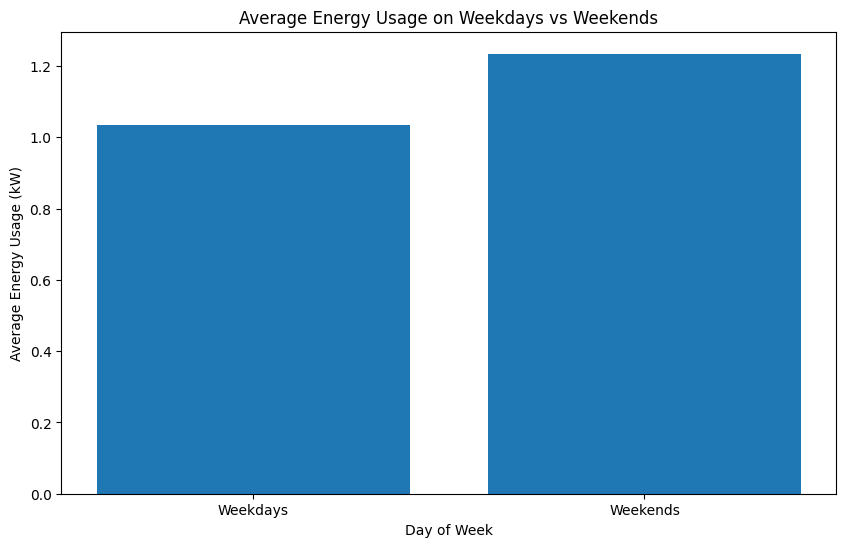

Execution Successful!


In [7]:
# Query 3: Weekdays vs weekends
execute_query("Compare average energy usage (Global_active_power) on weekdays vs weekends.")

In [8]:
# Query 4: High consumption days
execute_query("Find days where daily energy consumption exceeded 5 kWh. Return dates and consumption values.")

Query: Find days where daily energy consumption exceeded 5 kWh. Return dates and consumption values.
Generated Code:
```python
# Filter days where daily energy consumption exceeded 5 kWh
exceeded_days = df.resample('D').sum().reset_index()
exceeded_days = exceeded_days[exceeded_days['Global_active_power'] > 5]

# Select only the required columns
result = exceeded_days[['date', 'Global_active_power']]

print(result)
```

This code first resamples the data by day to calculate the daily sum of 'Global_active_power'. It then filters the result to include only days where the daily energy consumption exceeded 5 kWh. Finally, it selects only the 'date' and 'Global_active_power' columns for the final result.
Error: datetime64 type does not support sum operations


Query: Plot the energy usage trend for the first week of January 2007. Use line plot with datetime on x-axis.
Generated Code:
```python
import matplotlib.pyplot as plt

# Filter the data for the first week of January 2007
first_week_jan_2007 = df[(df['date'].dt.year == 2007) & 
                        (df['date'].dt.month == 1) & 
                        (df['date'].dt.day >= 1) & 
                        (df['date'].dt.day <= 7)]

# Plot the energy usage trend
plt.figure(figsize=(10,6))
plt.plot(first_week_jan_2007.index, first_week_jan_2007['Global_active_power'], label='Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.title('Energy Usage Trend for the First Week of January 2007')
plt.legend()
plt.show()
```


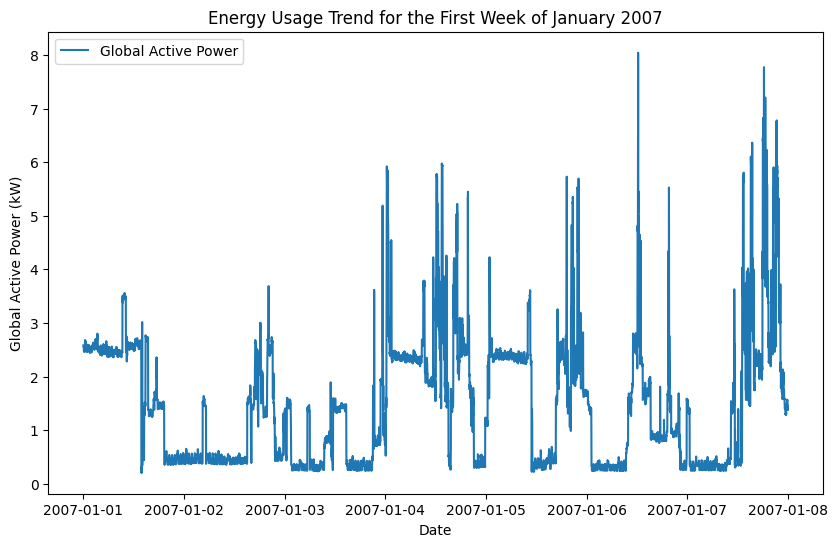

Execution Successful!


In [9]:
# Query 5: January 2007 trend plot
execute_query("Plot the energy usage trend for the first week of January 2007. Use line plot with datetime on x-axis.")

In [10]:
# Query 6: Average voltage in February 2007
execute_query("Find the average voltage for each day of the first week of February 2007.")

Query: Find the average voltage for each day of the first week of February 2007.
Generated Code:
```python
# Filter the data for the first week of February 2007
first_week_february_2007 = df[(df.index.year == 2007) & (df.index.month == 2) & (df.index.day >= 1) & (df.index.day <= 7)]

# Calculate the average voltage for each day
average_voltage_per_day = first_week_february_2007.groupby('day_of_week')['Voltage'].mean()

# Print the result
print(average_voltage_per_day)
```

This code will return a pandas Series with the average voltage for each day of the week in the first week of February 2007.
day_of_week
0    240.810312
1    241.264160
2    241.149694
3    240.392139
4    240.334389
5    238.910194
6    239.633333
Name: Voltage, dtype: float64
Execution Successful!


Query: Calculate correlation between Global_active_power and sub-metering columns (Sub_metering_1, Sub_metering_2, Sub_metering_3).
Generated Code:
```python
import pandas as pd
import matplotlib.pyplot as plt

# Calculate correlation between Global_active_power and sub-metering columns
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()['Global_active_power'].drop('Global_active_power')

print(correlation)

# Plot the correlation matrix
plt.figure(figsize=(10,6))
plt.bar(correlation.index, correlation.values)
plt.xlabel('Sub-metering Columns')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation between Global_active_power and Sub-metering Columns')
plt.show()
```
Sub_metering_1    0.484401
Sub_metering_2    0.434569
Sub_metering_3    0.638555
Name: Global_active_power, dtype: float64


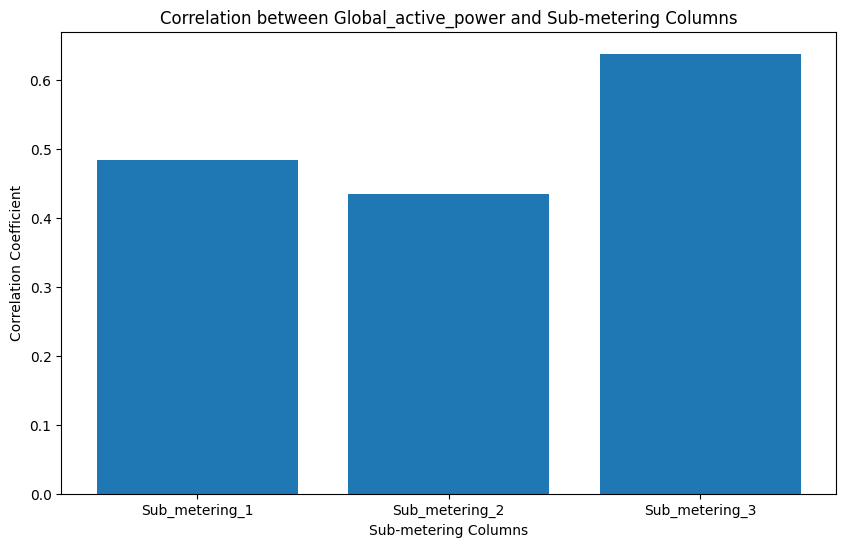

Execution Successful!


In [11]:
# Query 7: Correlation analysis
execute_query("Calculate correlation between Global_active_power and sub-metering columns (Sub_metering_1, Sub_metering_2, Sub_metering_3).")